In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
# from joblib import Parallel, delayed

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = 48
if ncore > mp.cpu_count():
    ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [4]:
###################### need to change start
ipts="29313"
###################### need to change end

## Find CT scan location

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_10_13_set2',
 '2022_10_14_high_res_norm',
 '2022_10_13_set1',
 '2022_10_14_high_res_ob',
 '2022_10_14_high_res_dc',
 '2022_10_14_high_res_ct']

## Find OB location

In [6]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_10_13_set2',
 '2022_10_14_high_res_norm',
 '2022_10_13_set1',
 '2022_10_14_high_res_ob',
 '2022_10_14_high_res_dc',
 '2022_10_14_high_res_ct']

## Find DC location

In [7]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_10_13_set2',
 '2022_10_14_high_res_norm',
 '2022_10_13_set1',
 '2022_10_14_high_res_ob',
 '2022_10_14_high_res_dc',
 '2022_10_14_high_res_ct']

In [8]:
###################### need to change start
sample_name = "2022_10_14_high_res_ct"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_10_14_high_res_ob")
dc_dir = os.path.join(dc_loc, "2022_10_14_high_res_dc")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will not be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 513 of angle 179.9
Found index of 0 degree projections: 0 of angle 0.35
Loading 1029 CT projections...


1029it [03:12,  5.34it/s]


1029 CT projections loaded!
Shape: (1029, 9300, 1800)
Loading 1 Open Beam (OB) images...


1it [00:00,  7.26it/s]


1 Open Beam (OB) images loaded!
Shape: (1, 9300, 1800)
Loading 1 Dark Current (DC) images...


1it [00:00,  9.74it/s]

1 Dark Current (DC) images loaded!
Shape: (1, 9300, 1800)


# Visual verification of loaded files

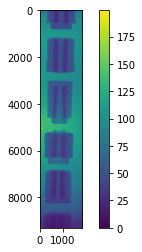

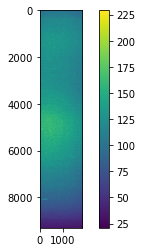

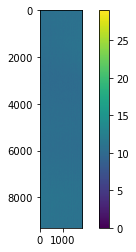

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


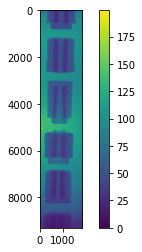

In [11]:
###################### need to change start
crop = False
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 550
crop_right = 1500
crop_top = 900
crop_bottom = 1450
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)

Time: 165.48678206600016 s


# Normalization

OB squeezed.
Only 1 OB loaded.
DC squeezed.
Only 1 DC loaded.
Normalizing...
Normalization Done!
float32
(1029, 9300, 1800)


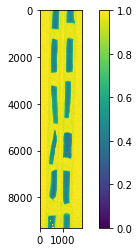

In [13]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)

In [14]:
proj_norm = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


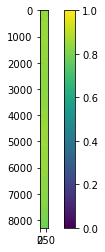

In [15]:
###################### need to change start
bg_left = 1500
bg_right = 1800
bg_top = 200
bg_bottom = 8500
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

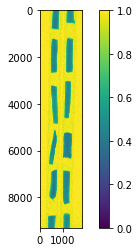

Time: 119.98987123300321 s


In [16]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

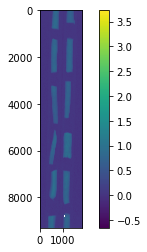

In [18]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)

In [19]:
proj_mlog = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

# Find and correct tilt

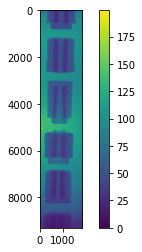

(9300, 1800)

In [20]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


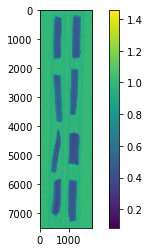

Tilt correction ROI at 180 degree:


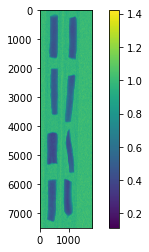

In [21]:
###################### need to change start
tt_left = 0
tt_right = 4000
tt_top = 1000
tt_bottom = 8500
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_180deg_mlog)
plt.colorbar()
plt.show()

In [48]:
print("Finding the tilt angle using transmission images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using transmission images...
Found the tilt angle:  -1.0526405008335602


In [22]:
print("Finding the tilt angle using minus log images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using minus log images...
Found the tilt angle:  -1.0526404842301758


In [23]:
t0 = timeit.default_timer()
# tilt_ang.x = 0.1248
proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3d/filters/tilt.py:115: TqdmWarning: Iterable length 1029 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


Applying tilt corr:   0%|          | 0/1029 [00:00<?, ?it/s]

Time cost 9.522868962850286 min


Projection at 0 degree:


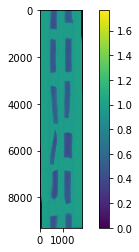

Projection at 180 degree (flipped):


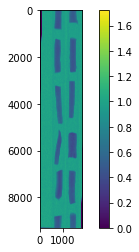

In [24]:
print("Projection at 0 degree:")
plt.imshow(proj_mlog_tilt[proj000_idx])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt[proj180_idx]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [25]:
history_dict

{'crop': False,
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 1500,
  'right': 1800,
  'top': 200,
  'bottom': 8500},
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 4000, 'top': 1000, 'bottom': 8500},
 'tilt_corr': -1.0526404842301758}

# Ring Artifact Removal

Before ring removal:


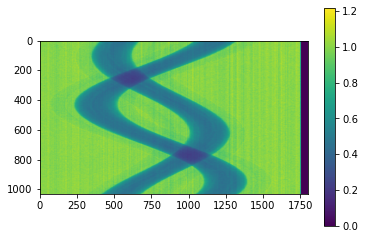

In [26]:
slice_num = 2000
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy

In [27]:
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_mlog_rmv_vo = tomopy.remove_all_stripe(proj_mlog_tilt, ncore=ncore, nchunk=nchunk)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'Vo')

Chunk size:  22


/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invalid value encountered in divide
  sinogram = sinogram / matfact
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invalid value encountered in divide
  sinogram = sinogram / matfact
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invalid value encountered in divide
  sinogram = sinogram / matfact
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invalid value encountered in divide
  sinogram = sinogram / matfact
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invalid value encountered in divide
  sinogram = sinogram / matfact
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/stripe.py:724: RuntimeWarning: invali

Time cost 16.8166109134836 min


Before ring removal:


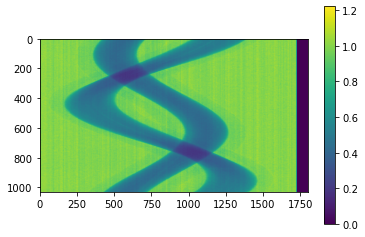

After ring removal:


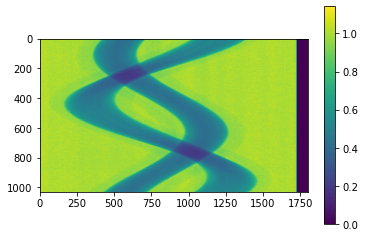

Difference:


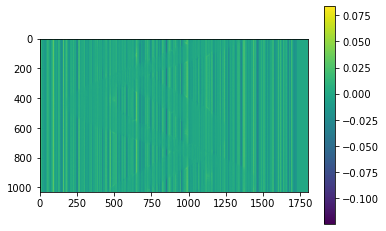

In [28]:
slice_num = 500
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach

In [ ]:
# t0 = timeit.default_timer()
# print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
# proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
# print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
# proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
# result = Parallel(n_jobs=ncore, prefer="threads")(delayed(bm3d.multiscale_streak_removal)(proj_mlog_bm3d[i], for i in range(n_slice))

# t1 = timeit.default_timer()
# print("Time cost {} min".format((t1-t0)/60))
# history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

In [ ]:
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

In [ ]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_proj_mlog_bm3d"
print('Saving files to ', save_to)
dxchange.write_tiff_stack(proj_mlog_bm3d, fname=save_to + "/mlog", overwrite=True, digit=4)

In [ ]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [29]:
proj_mlog_to_recon = proj_mlog_rmv_vo.astype(np.float32)
# proj_mlog_to_recon = proj_mlog_rmv_bm3d.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [46]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 899.5


In [30]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
# rot_center = calc.find_center_360(sino_mlog_to_recon[200], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 808.7867736816406


# Reconstruction

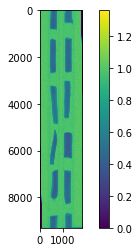

In [31]:
plt.imshow(proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

808.7867736816406


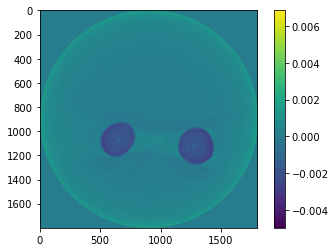

In [37]:
print(rot_center)
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[2300], rot_center, angles=ang_rad, apply_log=False)
plt.imshow(rec_img1)#, vmin=-0.006, vmax=0.002)
plt.colorbar()
plt.show()

In [40]:
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_600_1200"
pix_um = 5.37 #um
pix_cm = pix_um/10000
history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
t0 = timeit.default_timer()
recon_algo = 'gridrec'
for h_idx in range(sino_mlog_to_recon.shape[0]):
    _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False)
    _rec_slice_cm = _rec_slice/pix_cm
    _slice_name = save_to + "/recon_" + f'{h_idx:05d}'
    print('Saving {} ...'.format(_slice_name))
    dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00000 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00001 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00002 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00003 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00004 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00005 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00006 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00007 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00008 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00009 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00089 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00090 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00091 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00092 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00093 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00094 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00095 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00096 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00097 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00098 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00178 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00179 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00180 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00181 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00182 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00183 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00184 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00185 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00186 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00187 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00267 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00268 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00269 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00270 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00271 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00272 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00273 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00274 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00275 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00276 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00356 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00357 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00358 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00359 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00360 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00361 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00362 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00363 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00364 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00365 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00445 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00446 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00447 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00448 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00449 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00450 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00451 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00452 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00453 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00454 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00534 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00535 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00536 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00537 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00538 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00539 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00540 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00541 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00542 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00543 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00623 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00624 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00625 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00626 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00627 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00628 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00629 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00630 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00631 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00632 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00712 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00713 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00714 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00715 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00716 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00717 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00718 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00719 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00720 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00721 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00801 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00802 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00803 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00804 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00805 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00806 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00807 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00808 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00809 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00810 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00890 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00891 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00892 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00893 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00894 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00895 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00896 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00897 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00898 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00899 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00979 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00980 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00981 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00982 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00983 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00984 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00985 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00986 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00987 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_00988 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01068 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01069 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01070 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01071 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01072 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01073 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01074 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01075 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01076 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01077 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01157 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01158 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01159 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01160 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01161 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01162 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01163 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01164 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01165 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01166 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01246 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01247 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01248 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01249 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01250 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01251 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01252 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01253 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01254 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01255 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01335 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01336 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01337 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01338 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01339 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01340 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01341 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01342 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01343 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01344 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01424 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01425 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01426 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01427 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01428 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01429 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01430 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01431 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01432 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01433 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01513 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01514 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01515 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01516 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01517 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01518 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01519 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01520 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01521 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01522 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01602 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01603 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01604 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01605 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01606 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01607 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01608 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01609 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01610 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01611 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01691 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01692 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01693 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01694 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01695 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01696 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01697 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01698 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01699 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01700 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01780 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01781 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01782 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01783 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01784 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01785 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01786 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01787 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01788 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01789 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01869 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01870 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01871 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01872 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01873 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01874 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01875 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01876 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01877 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01878 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01958 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01959 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01960 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01961 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01962 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01963 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01964 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01965 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01966 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_01967 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02047 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02048 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02049 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02050 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02051 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02052 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02053 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02054 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02055 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02056 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02136 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02137 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02138 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02139 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02140 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02141 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02142 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02143 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02144 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02145 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02225 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02226 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02227 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02228 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02229 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02230 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02231 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02232 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02233 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02234 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02314 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02315 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02316 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02317 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02318 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02319 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02320 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02321 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02322 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02323 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02403 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02404 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02405 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02406 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02407 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02408 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02409 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02410 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02411 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02412 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02492 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02493 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02494 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02495 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02496 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02497 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02498 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02499 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02500 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02501 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02581 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02582 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02583 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02584 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02585 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02586 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02587 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02588 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02589 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02590 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02670 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02671 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02672 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02673 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02674 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02675 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02676 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02677 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02678 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02679 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02759 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02760 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02761 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02762 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02763 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02764 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02765 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02766 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02767 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02768 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02848 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02849 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02850 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02851 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02852 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02853 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02854 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02855 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02856 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02857 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02937 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02938 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02939 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02940 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02941 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02942 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02943 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02944 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02945 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_02946 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03026 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03027 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03028 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03029 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03030 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03031 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03032 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03033 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03034 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03035 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03115 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03116 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03117 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03118 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03119 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03120 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03121 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03122 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03123 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03124 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03204 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03205 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03206 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03207 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03208 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03209 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03210 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03211 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03212 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03213 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03293 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03294 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03295 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03296 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03297 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03298 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03299 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03300 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03301 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03302 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03382 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03383 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03384 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03385 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03386 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03387 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03388 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03389 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03390 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03391 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03471 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03472 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03473 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03474 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03475 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03476 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03477 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03478 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03479 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03480 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03560 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03561 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03562 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03563 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03564 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03565 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03566 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03567 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03568 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03569 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03649 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03650 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03651 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03652 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03653 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03654 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03655 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03656 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03657 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03658 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03738 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03739 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03740 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03741 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03742 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03743 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03744 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03745 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03746 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03747 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03827 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03828 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03829 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03830 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03831 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03832 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03833 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03834 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03835 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03836 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03916 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03917 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03918 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03919 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03920 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03921 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03922 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03923 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03924 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_03925 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04005 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04006 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04007 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04008 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04009 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04010 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04011 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04012 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04013 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04014 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04094 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04095 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04096 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04097 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04098 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04099 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04100 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04101 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04102 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04103 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04183 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04184 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04185 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04186 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04187 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04188 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04189 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04190 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04191 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04192 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04272 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04273 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04274 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04275 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04276 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04277 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04278 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04279 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04280 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04281 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04361 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04362 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04363 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04364 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04365 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04366 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04367 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04368 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04369 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04370 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04450 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04451 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04452 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04453 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04454 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04455 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04456 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04457 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04458 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04459 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04539 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04540 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04541 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04542 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04543 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04544 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04545 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04546 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04547 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04548 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04628 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04629 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04630 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04631 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04632 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04633 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04634 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04635 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04636 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04637 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04717 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04718 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04719 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04720 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04721 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04722 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04723 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04724 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04725 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04726 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04806 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04807 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04808 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04809 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04810 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04811 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04812 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04813 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04814 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04815 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04895 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04896 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04897 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04898 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04899 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04900 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04901 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04902 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04903 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04904 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04984 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04985 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04986 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04987 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04988 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04989 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04990 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04991 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04992 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_04993 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05073 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05074 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05075 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05076 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05077 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05078 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05079 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05080 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05081 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05082 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05162 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05163 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05164 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05165 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05166 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05167 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05168 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05169 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05170 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05171 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05251 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05252 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05253 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05254 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05255 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05256 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05257 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05258 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05259 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05260 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05340 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05341 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05342 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05343 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05344 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05345 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05346 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05347 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05348 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05349 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05429 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05430 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05431 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05432 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05433 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05434 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05435 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05436 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05437 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05438 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05518 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05519 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05520 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05521 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05522 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05523 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05524 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05525 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05526 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05527 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05607 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05608 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05609 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05610 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05611 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05612 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05613 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05614 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05615 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05616 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05696 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05697 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05698 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05699 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05700 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05701 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05702 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05703 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05704 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05705 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05785 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05786 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05787 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05788 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05789 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05790 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05791 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05792 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05793 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05794 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05874 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05875 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05876 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05877 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05878 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05879 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05880 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05881 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05882 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05883 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05963 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05964 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05965 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05966 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05967 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05968 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05969 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05970 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05971 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_05972 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06052 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06053 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06054 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06055 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06056 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06057 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06058 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06059 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06060 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06061 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06141 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06142 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06143 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06144 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06145 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06146 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06147 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06148 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06149 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06150 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06230 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06231 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06232 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06233 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06234 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06235 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06236 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06237 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06238 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06239 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06319 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06320 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06321 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06322 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06323 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06324 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06325 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06326 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06327 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06328 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06408 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06409 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06410 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06411 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06412 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06413 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06414 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06415 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06416 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06417 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06497 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06498 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06499 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06500 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06501 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06502 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06503 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06504 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06505 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06506 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06586 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06587 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06588 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06589 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06590 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06591 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06592 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06593 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06594 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06595 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06675 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06676 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06677 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06678 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06679 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06680 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06681 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06682 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06683 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06684 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06764 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06765 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06766 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06767 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06768 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06769 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06770 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06771 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06772 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06773 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06853 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06854 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06855 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06856 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06857 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06858 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06859 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06860 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06861 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06862 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06942 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06943 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06944 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06945 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06946 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06947 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06948 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06949 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06950 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_06951 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07031 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07032 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07033 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07034 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07035 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07036 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07037 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07038 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07039 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07040 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07120 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07121 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07122 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07123 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07124 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07125 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07126 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07127 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07128 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07129 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07209 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07210 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07211 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07212 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07213 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07214 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07215 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07216 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07217 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07218 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07298 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07299 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07300 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07301 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07302 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07303 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07304 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07305 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07306 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07307 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07387 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07388 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07389 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07390 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07391 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07392 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07393 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07394 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07395 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07396 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07476 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07477 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07478 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07479 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07480 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07481 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07482 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07483 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07484 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07485 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07565 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07566 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07567 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07568 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07569 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07570 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07571 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07572 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07573 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07574 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07654 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07655 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07656 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07657 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07658 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07659 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07660 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07661 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07662 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07663 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07743 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07744 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07745 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07746 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07747 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07748 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07749 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07750 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07751 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07752 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07832 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07833 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07834 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07835 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07836 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07837 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07838 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07839 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07840 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07841 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07921 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07922 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07923 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07924 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07925 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07926 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07927 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07928 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07929 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_07930 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08010 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08011 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08012 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08013 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08014 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08015 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08016 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08017 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08018 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08019 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08099 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08100 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08101 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08102 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08103 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08104 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08105 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08106 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08107 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08108 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08188 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08189 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08190 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08191 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08192 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08193 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08194 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08195 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08196 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08197 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08277 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08278 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08279 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08280 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08281 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08282 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08283 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08284 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08285 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08286 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08366 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08367 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08368 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08369 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08370 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08371 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08372 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08373 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08374 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08375 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08455 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08456 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08457 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08458 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08459 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08460 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08461 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08462 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08463 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08464 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08544 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08545 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08546 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08547 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08548 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08549 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08550 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08551 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08552 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08553 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08633 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08634 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08635 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08636 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08637 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08638 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08639 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08640 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08641 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08642 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08722 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08723 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08724 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08725 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08726 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08727 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08728 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08729 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08730 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08731 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08811 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08812 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08813 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08814 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08815 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08816 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08817 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08818 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08819 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08820 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08900 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08901 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08902 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08903 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08904 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08905 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08906 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08907 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08908 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08909 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08989 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08990 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08991 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08992 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08993 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08994 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08995 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08996 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08997 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_08998 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09078 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09079 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09080 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09081 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09082 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09083 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09084 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09085 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09086 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09087 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09167 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09168 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09169 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09170 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09171 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09172 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09173 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09174 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09175 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09176 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09256 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09257 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09258 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09259 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09260 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09261 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09262 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09263 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09264 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_res_ct/recon_09265 ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/rockit/2022_10_14_high_

# Export to HDF5

In [ ]:
history_dict

In [42]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
#     f.create_dataset('tomo/recon/recon_volume', data=recon_cm)

In [ ]:
# if not os.path.exists(output_hdf5_dir):
#     os.mkdir(output_hdf5_dir)
# with h5f.File(output_hdf5, mode='a') as f:
#     f.create_group('tomo/raw_ref')
#     f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
#     f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
#     f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
#     f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
#     f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
#     f.create_group('tomo/proj')
#     f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
# #     f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
#     f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
#     f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
#     f.create_group('tomo/sino')
# #     f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
# #     f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
#     f.create_group('tomo/info')
#     f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
#     f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
#     f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
#     f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
#     f.create_dataset('tomo/info/fname', data=fname_sorted)
#     f.create_group('tomo/recon')
#     f.create_dataset('tomo/recon/history', data=(str(history_dict),))
# #     f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
# #     f.create_dataset('tomo/recon/recon_volume', data=recon_cm)